## Do synonyms reside locally in semantic embedding?

clone medialpy and uninitiate git inside (because the outer files are inside a git already)



In [ ]:
# !git clone git@github.com:AberystwythSystemsBiology/MEDIALpy.git
# !rm -rf MEDIALpy/.git
# !rm -rf MEDIALpy/.gitignore
# !rm -rf MEDIALpy/.github

fatal: destination path 'MEDIALpy' already exists and is not an empty directory.


In [2]:
import gzip
import json

from typing import Optional

# here = os.path.dirname(os.path.abspath(__file__))

with gzip.open("MEDIALpy/medialpy/abbrv.json.gz") as infile:
    annotations = json.load(infile)


len(annotations.keys())

3025

In [3]:
# !pip install medialpy



In [4]:
import medialpy

term = medialpy.find("T1DM")
term.abbreviation
term.meaning



['type 1 Diabetes Mellitus']

In [5]:
term.abbreviation

'T1DM'

In [6]:
# Load model directly
from transformers import AutoTokenizer, AutoModel


from transformers import pipeline
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-v1.1")#.to(device)
model = AutoModel.from_pretrained("dmis-lab/biobert-v1.1").to(device)



/home/hao/anaconda3/envs/gr/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
term2 = medialpy.find("ADHD")

term2.abbreviation
term2.meaning

['attention deficit hyperactivity disorder']

In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def compute_pairwise_cosine_sims_torch(list1, list2, batch_size=32):
    # Convert to tensors and move to GPU if available
    list1 = torch.tensor(list1, device=device)
    list2 = torch.tensor(list2, device=device)

    similarities = []
    for i in range(0, list1.size(0), batch_size):
        batch1 = list1[i:i+batch_size]
        batch2 = list2[i:i+batch_size]

        # Normalize tensors
        batch1_norm = batch1 / torch.linalg.norm(batch1, dim=1, keepdim=True)
        batch2_norm = batch2 / torch.linalg.norm(batch2, dim=1, keepdim=True)

        # Compute pairwise cosine similarity
        batch_sim = torch.sum(batch1_norm * batch2_norm, dim=1)
        
        similarities.append(batch_sim.cpu())

    # Concatenate and convert to numpy
    similarities = torch.cat(similarities).numpy()
    return similarities

# Example usage

[1.        0.9999999 1.        1.       ]


In [10]:
all_terms = annotations.keys()

l = len(all_terms)
terms = [medialpy.find(term) for term in all_terms]
all_abbr = []
all_meaning = []
for term in terms:
    all_abbr.append(str(term.abbreviation))
    all_meaning.append(str(term.meaning))

all_text = all_abbr + all_meaning
with torch.no_grad():
    model.eval()
    # model.to(device)
    # tokenizer.to(device)
    tokenized_term = tokenizer(all_text, return_tensors='pt', padding=True, truncation=True).to(device)
    
    embedding = model(**tokenized_term).last_hidden_state[:,0,:].detach().cpu().numpy() #CLS approach
    
sims = compute_pairwise_cosine_sims_torch(embedding[:l, :], embedding[l:, :], batch_size=16)

In [12]:
import numpy as np

# Shuffle the second half of the embedding
shuffled_embedding = embedding[l:, :].copy()
np.random.shuffle(shuffled_embedding)

# Compute sims2
sims2 = compute_pairwise_cosine_sims_torch(embedding[:l, :], shuffled_embedding, batch_size=16)

(array([  1.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   2.,
          0.,   1.,   0.,   0.,   1.,   2.,   2.,   1.,   2.,   3.,   2.,
          2.,   4.,   6.,   5.,   4.,   6.,   4.,   8.,   8.,   9.,   9.,
          7.,   8.,  11.,  10.,  15.,   9.,  20.,  26.,  35.,  27.,  32.,
         43.,  41.,  51.,  50.,  59.,  65.,  73.,  68.,  80.,  84.,  81.,
         83.,  96.,  87.,  94., 106., 117., 105., 100., 132., 104., 107.,
        108.,  84.,  91.,  82.,  81.,  74.,  74.,  65.,  47.,  32.,  34.,
         26.,  22.,  22.,  16.,  12.,  11.,   9.,   6.,   5.,   5.,   5.,
          3.]),
 array([0.66433501, 0.66691363, 0.66949224, 0.67207086, 0.67464948,
        0.67722815, 0.67980677, 0.68238539, 0.684964  , 0.68754262,
        0.69012123, 0.69269985, 0.69527847, 0.69785708, 0.70043576,
        0.70301437, 0.70559299, 0.70817161, 0.71075022, 0.71332884,
        0.71590745, 0.71848607, 0.72106469, 0.

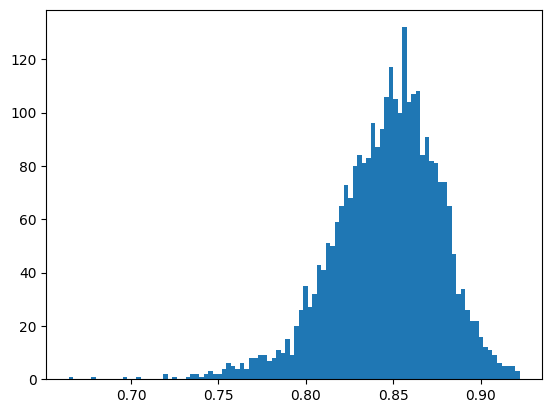

In [11]:
from matplotlib import pyplot as plt
plt.hist(sims, bins=100)

(array([  1.,   0.,   0.,   1.,   2.,   0.,   0.,   0.,   1.,   1.,   0.,
          1.,   1.,   1.,   0.,   0.,   0.,   0.,   1.,   0.,   2.,   0.,
          1.,   0.,   4.,   0.,   1.,   6.,   4.,   3.,   3.,   3.,   4.,
          3.,   8.,  10.,  10.,   4.,   6.,   9.,  16.,  11.,   8.,  13.,
         17.,  21.,  20.,  27.,  33.,  32.,  28.,  48.,  40.,  62.,  39.,
         59.,  65.,  63.,  81.,  83.,  95.,  92., 109.,  88., 115.,  86.,
        103., 112.,  99., 106., 101.,  91., 101.,  93.,  86.,  76.,  68.,
         75.,  79.,  69.,  67.,  58.,  44.,  35.,  32.,  23.,  16.,  14.,
          9.,   9.,   6.,   5.,   3.,   1.,   0.,   0.,   1.,   0.,   0.,
          1.]),
 array([0.67127037, 0.67370695, 0.67614353, 0.67858005, 0.68101662,
        0.6834532 , 0.68588978, 0.68832636, 0.69076288, 0.69319946,
        0.69563603, 0.69807261, 0.70050913, 0.70294571, 0.70538229,
        0.70781887, 0.71025544, 0.71269196, 0.71512854, 0.71756512,
        0.7200017 , 0.72243828, 0.72487479, 0.

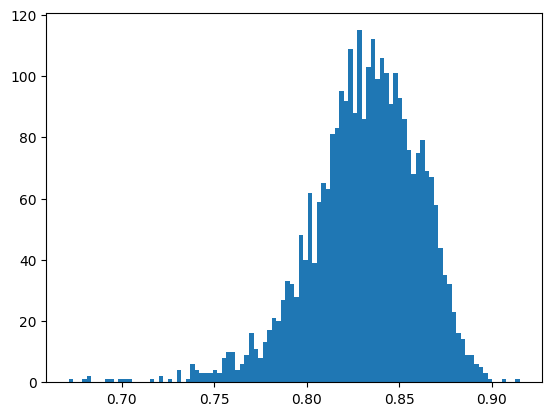

In [13]:
plt.hist(sims2, bins=100)